In [1]:
import os
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import col 
from pyspark.mllib.evaluation import MulticlassMetrics


spark = SparkSession.builder.getOrCreate()

## Data Import and Preprocessing 

In [2]:
df = spark.read.csv('data.csv', inferSchema=True, header = True)

In [3]:
df.count()

6819

In [3]:
# Look for columns with null values
null_col = []
for c in df.columns:
    if not df.where(col(c).isNull()).limit(1).collect() == []:
        null_col.append(c)
print(null_col)

[]


In [4]:
# Examine class balance
print('Number of Non-bankrupt Companies: ', df.where(col('Bankrupt?') == 0).count(),
      ', %: ', round(df.where(col('Bankrupt?') == 0).count()/df.count()*100, 2))
print('Number of Bankrupt Companies: ', df.where(col('Bankrupt?') == 1).count(),
      ', %: ', round(df.where(col('Bankrupt?') == 1).count()/df.count()*100, 2))

Number of Non-bankrupt Companies:  6599 , %:  96.77
Number of Bankrupt Companies:  220 , %:  3.23


In [5]:
import pandas as pd

pd.set_option('display.max_columns', None)

df.select("*").describe().toPandas()

,summary,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,count,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819,6819
1,mean,0.03226279513125092,0.505179633241782,0.5586249158750473,0.5535887093516647,0.6079480383703836,0.6079294691769787,0.9987551277900453,0.7971897524712888,0.8090835935135369,0.30362292364973476,0.7813814325261427,1.9953473128027918E9,1.950427306056799E9,0.46743118577966175,1.6448012905942492E7,0.11500074794142456,0.19066057949747367,0.1906331789677462,0.19067237025316164,0.22881285256452713,0.32348191216983185,1328640.6020960642,0.10909073887546941,0.1843605776420337,0.02240785447416586,0.8479799951688057,0.689146118568132,0.6891500117795625,0.2176390129969667,5.508096595248731E9,1566212.0552410616,0.2642475118758422,0.37967667232266256,403284.9542449723,8376594.819684908,0.6309910117124122,4416336.714259364,0.11317708497306005,0.8868229150269425,0.008782733815036815,0.37465429459871874,0.0059682772664793535,0.10897668140

A lot of features seem to be percentages or ratios, basically between 0 and 1. Might consider standardizing the features using StandardScalar so that the features are normalized to have unit standard deviation. Also consider that the Net Income Flag has values of 1 for every observation, could consider removing it altogether.

In [28]:
# scale features

from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
feature_names = [i for i in df.columns[1:]]
feature_names.remove(' Net Income Flag')


assembler = VectorAssembler(inputCols = feature_names, outputCol = 'features')
df2 = assembler.transform(df).withColumnRenamed('Bankrupt?', 'label').select('label', 'features')

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", 
                                withStd=True, withMean=False)

# Fit the DataFrame to the scaler; this computes the mean, standard deviation of each feature
scaler = standardScaler.fit(df2)

# Transform the data in `df2` with the scaler
scaled_df = scaler.transform(df2).drop('features')

Take a look at correlation between explanatory variables

In [29]:
from pyspark.ml.stat import Correlation

vector_col = "corr_features"

assembler = VectorAssembler(inputCols=feature_names, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

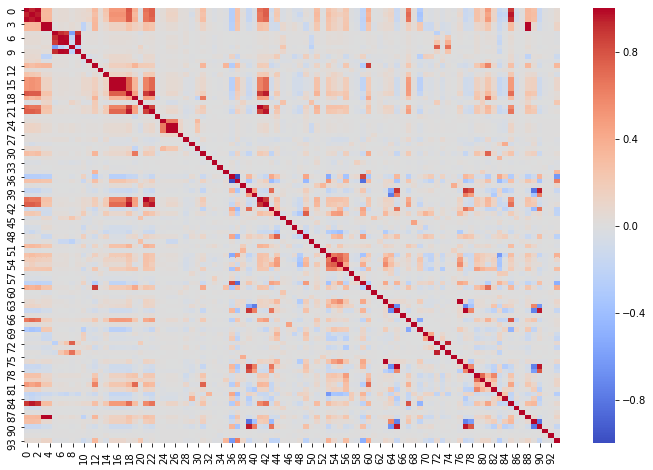

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corrmatrix, vmin=-1, vmax=1, center=0, cmap= 'coolwarm')
plt.rcParams["figure.figsize"] = [12,8]
plt.show()

It seems like there isn't much correlation between explanatory variables, dimensionality reduction might not be necessary.

## Data Splitting/Sampling

In [8]:
# split the data into training and testing sets

train_test = [0.8,0.2]
train_data, test_data = scaled_df.randomSplit(train_test, seed=314)

In [9]:
# check class balance in train and test set

print('Number of Non-bankrupt Companies: ', train_data.where(col('label') == 0).count(),
      ', %: ', round(train_data.where(col('label') == 0).count()/train_data.count()*100, 2))
print('Number of Bankrupt Companies: ', train_data.where(col('label') == 1).count(),
      ', %: ', round(train_data.where(col('label') == 1).count()/train_data.count()*100, 2))
print('-'*40)
print('Number of Non-bankrupt Companies: ', test_data.where(col('label') == 0).count(),
      ', %: ', round(test_data.where(col('label') == 0).count()/test_data.count()*100, 2))
print('Number of Bankrupt Companies: ', test_data.where(col('label') == 1).count(),
      ', %: ', round(test_data.where(col('label') == 1).count()/test_data.count()*100, 2))

Number of Non-bankrupt Companies:  5240 , %:  96.98
Number of Bankrupt Companies:  163 , %:  3.02
----------------------------------------
Number of Non-bankrupt Companies:  1359 , %:  95.97
Number of Bankrupt Companies:  57 , %:  4.03


The training and test sets seem to have class balances that are fairly representative of the whole data.


However, because of the extreme class imbalance within the data itself, the model is likely to just predict non-bankrupt on all observations to achieve what would be 95.57% accuracy in the test set. Thus, applying some sort of sampling method (oversampling or undersampling) is recommended to combat this. In this case, since the data is relatively small (less than 10,000 observations), oversampling may be more useful.

In [10]:
# implement smote function

import random
import numpy as np
from functools import reduce
import pyspark.sql.functions as F
from pyspark.sql import Row
from pyspark.sql.functions import rand,col,when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.window import *
from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler,BucketedRandomProjectionLSH,VectorSlicer
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors,VectorUDT
from pyspark.sql.functions import array, create_map, struct

def smote(vectorized_df, k, batches):
    # split the vectorized dataframe by class
    min_obs = vectorized_df.where(col('label') == 1)
    max_obs = vectorized_df.where(col('label') == 0)
    
    # Initialize bucketed random projection for euclidean distance
    brp = BucketedRandomProjectionLSH(inputCol = 'features_scaled', outputCol = 'hashes',seed = 314,
                                      bucketLength = 100)
    # fit only to minority observations
    model = brp.fit(min_obs)
    model.transform(min_obs)
    
    # compute locality sensitive hashes for input rows within the same dataframe, 
    distances = model.approxSimilarityJoin(min_obs, min_obs, float('inf'),
                                               distCol = 'EuclideanDistance')
    # remove self-references
    distances = distances.filter(col('EuclideanDistance') > 0)
    
    over_original_rows = Window.partitionBy('datasetA').orderBy('EuclideanDistance')
    self_similarity = distances.withColumn('r_num', F.row_number().over(over_original_rows))
    self_similarity_selected = self_similarity.filter(col('r_num') <= k)
    over_original_rows_unordered = Window.partitionBy('datasetA')
    
    # list to store synthetic data
    synth = []
    
    # define functions for adding and subtracting vectors
    subtract_vector = F.udf(lambda arr: random.uniform(0,1)*(arr[0]-arr[1]), VectorUDT())
    add_vector = F.udf(lambda arr: arr[0]+arr[1], VectorUDT())
    
    # create synthetic data
    # each batch creates len(min_obs) number of synthetic observations
    for i in range(batches):
        print('generating batch %s of synthetic instances'%i)
        df_random_sel = self_similarity_selected.withColumn("rand", F.rand()).withColumn('max_rand', F.max('rand')\
                                                                                         .over(over_original_rows_unordered))\
                            .where(F.col('rand') == F.col('max_rand')).drop(*['max_rand','rand','r_num'])
        # create synthetic feature numerical part
        df_vec_diff = df_random_sel.select('*', subtract_vector(F.array('datasetA.features_scaled', 'datasetB.features_scaled')).alias('vec_diff'))
        df_vec_modified = df_vec_diff.select('*', add_vector(F.array('datasetA.features_scaled', 'vec_diff')).alias('features_scaled'))
        
        df_vec_modified = df_vec_modified.drop(*['datasetA', 'datasetB', 'vec_diff', 'EuclideanDistance'])
        
        synth.append(df_vec_modified)
        
    dfunion = reduce(DataFrame.unionAll, synth)
    df_w_labels = dfunion.select(lit(1).alias('label'),col('features_scaled'))
    
    oversampled_df = vectorized_df.union(df_w_labels)
    
    return oversampled_df

In [11]:
oversampled_train = smote(train_data, 4, 30)

generating batch 0 of synthetic instances
generating batch 1 of synthetic instances
generating batch 2 of synthetic instances
generating batch 3 of synthetic instances
generating batch 4 of synthetic instances
generating batch 5 of synthetic instances
generating batch 6 of synthetic instances
generating batch 7 of synthetic instances
generating batch 8 of synthetic instances
generating batch 9 of synthetic instances
generating batch 10 of synthetic instances
generating batch 11 of synthetic instances
generating batch 12 of synthetic instances
generating batch 13 of synthetic instances
generating batch 14 of synthetic instances
generating batch 15 of synthetic instances
generating batch 16 of synthetic instances
generating batch 17 of synthetic instances
generating batch 18 of synthetic instances
generating batch 19 of synthetic instances
generating batch 20 of synthetic instances
generating batch 21 of synthetic instances
generating batch 22 of synthetic instances
generating batch 23 o

In [ ]:
# recheck oversampled training data class balance
print('Number of Non-bankrupt Companies: ', oversampled_train.where(col('label') == 0).count(),
      ', %: ', round(oversampled_train.where(col('label') == 0).count()/oversampled_train.count()*100, 2))
print('Number of Bankrupt Companies: ', oversampled_train.where(col('label') == 1).count(),
      ', %: ', round(oversampled_train.where(col('label') == 1).count()/oversampled_train.count()*100, 2))

In [ ]:
# model with svm
from pyspark.ml.classification import LinearSVC

# scaled_df.show(2)
training, testing = scaled_df.randomSplit([0.8, 0.2], seed=314)
svm = LinearSVC(featuresCol = 'features_scaled', labelCol ='label',maxIter=10, regParam=0.1)
# Fit the model
svm_train = svm.fit(training)

svm_pred = svm_train.transform(testing)
eval = RegressionEvaluator(labelCol = 'label', predictionCol = 'prediction', metricName='rmse')
mse_svm = eval.evaluate(svm_pred, {eval.metricName: "mse"})
print('MSE: %.3f' % mse_svm)

In [ ]:
# model with logit
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features_scaled', labelCol ='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
# Fit the model
logit_train = lr.fit(training)
trainingSummary = logit_train.summary
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

logit_pred = logit_train.transform(testing)
testingSummary = logit_pred.summary

eval = RegressionEvaluator(labelCol = 'label', predictionCol = 'prediction', metricName='rmse')
mse_logit = eval.evaluate(logit_pred, {eval.metricName: "mse"})
print('MSE: %.3f' % mse_logit)

In [143]:
# model with linear regression
from pyspark.ml.regression import LinearRegression

maxIter=10
regParam=0.3
elasticNetParam=0.8
lr = LinearRegression(featuresCol = 'features_scaled', labelCol ='label', maxIter = maxIter, regParam = regParam, elasticNetParam = elasticNetParam)
lr_fit = lr.fit(training)

In [144]:
trainSummary = lr_fit.summary
print("RMSE: %f" % trainSummary.rootMeanSquaredError)
print("\nr2: %f" % trainSummary.r2)

RMSE: 0.171051

r2: 0.000000


In [145]:
from pyspark.ml.evaluation import RegressionEvaluator
lrPred = lr_fit.transform(testing)
eval = RegressionEvaluator(labelCol = 'label', predictionCol = 'prediction', metricName='rmse')
mse1 = eval.evaluate(lrPred, {eval.metricName: "mse"})
print('MSE: %.3f' % mse1)

MSE: 0.039
